In [1]:
pip install numpy matplotlib scipy torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

In [3]:
SEQ_LEN = 100  # Sequence length of past observations
INPUT_DIM = 3  # Three-variable trajectory (e.g., position, velocity, acceleration)
MODEL_DIM = 128  # Transformer model dimension
NUM_HEADS = 8  # Attention heads
NUM_LAYERS = 4  # Number of transformer layers
BATCH_SIZE = 32  # Mini-batch size
EPOCHS = 200  # Training epochs
LR = 1e-3  # Learning rate

# Memory Kernel function (tensor-compatible)
def memory_kernel(t, tau):
    """Compute the memory kernel function"""
    return torch.exp(-torch.abs(t - tau))

# Generate synthetic trajectory data with memory effects
def generate_synthetic_data(num_samples=1000, seq_len=SEQ_LEN):
    """Simulates trajectory data with memory-dependent dynamics."""
    t = torch.linspace(0, 10, seq_len * num_samples)  # Use PyTorch tensor from the start
    r_t = torch.sin(t) + 0.1 * torch.randn(len(t))  # Simulated position
    v_t = torch.gradient(r_t, spacing=(t,))[0]  # Compute velocity
    a_t = torch.gradient(v_t, spacing=(t,))[0]  # Compute acceleration

    # Apply memory kernel integral approximation
    memory_term = torch.zeros_like(v_t)
    for i in range(1, len(t)):
        tau = t[:i]  # Past times
        kernel_vals = memory_kernel(t[i], tau)  # Compute kernel
        dtau = t[i] - tau  # Compute time differences
        memory_term[i] = torch.sum(kernel_vals * v_t[:i] * dtau)  # Integral sum

    # Stochastic forcing
    noise = 0.1 * torch.randn_like(r_t)
    r_t = r_t + memory_term + noise  # Keep all operations in PyTorch

    # Stack position, velocity, and acceleration as features
    data = torch.stack([r_t, v_t, a_t], dim=-1)  # Shape (num_samples * seq_len, 3)
    data = data.view(num_samples, seq_len, INPUT_DIM)  # Proper reshaping
    return data

In [4]:
data = generate_synthetic_data()
X_train = data[:, :-1, :]  # Input sequence
Y_train = data[:, 1:, :]  # Next-step predictions

# Normalize data
mean, std = X_train.mean(), X_train.std()
X_train = (X_train - mean) / std
Y_train = (Y_train - mean) / std

# Split into training and validation sets
val_size = int(0.2 * len(data))
X_val, Y_val = X_train[-val_size:], Y_train[-val_size:]
X_train, Y_train = X_train[:-val_size], Y_train[:-val_size]

train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Transformer Model Definition incorporating memory effects
class TransformerDynamics(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, seq_len):
        super(TransformerDynamics, self).__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        self.positional_encoding = nn.Parameter(torch.randn(1, seq_len, model_dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.decoder = nn.Linear(model_dim, input_dim)

    def forward(self, x):
        x = self.embedding(x) + self.positional_encoding[:, :x.shape[1], :]
        x = self.transformer_encoder(x)
        x = self.decoder(x)

        # Memory kernel application (efficient batch-wise computation)
        seq_len = x.shape[1]
        memory_term = torch.zeros_like(x)

        for i in range(1, seq_len):
            tau = torch.arange(i, device=x.device).float()
            kernel_vals = memory_kernel(i, tau).unsqueeze(0).unsqueeze(-1)  # Shape (1, i, 1)
            dtau = (i - tau).unsqueeze(0).unsqueeze(-1)  # Shape (1, i, 1)
            memory_term[:, i, :] = torch.sum(kernel_vals * x[:, :i, :] * dtau, dim=1)

        # Stochastic noise
        noise = 0.1 * torch.randn_like(x)
        return x + memory_term + noise

# Initialize Model
model = TransformerDynamics(INPUT_DIM, MODEL_DIM, NUM_HEADS, NUM_LAYERS, SEQ_LEN-1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Training Loop with Validation
best_val_loss = float('inf')
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, Y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val_batch, Y_val_batch in val_loader:
            output = model(X_val_batch)
            val_loss += criterion(output, Y_val_batch).item()

    train_loss = total_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_transformer_dynamics.pth")

Epoch 0: Train Loss = 3.130499, Val Loss = 1.003953
Epoch 10: Train Loss = 0.134789, Val Loss = 0.057982
Epoch 20: Train Loss = 0.051132, Val Loss = 0.034658
Epoch 30: Train Loss = 0.037408, Val Loss = 0.031712
Epoch 40: Train Loss = 0.033606, Val Loss = 0.027585
Epoch 50: Train Loss = 0.030247, Val Loss = 0.027445
Epoch 60: Train Loss = 0.027967, Val Loss = 0.024610
Epoch 70: Train Loss = 0.026249, Val Loss = 0.025743
Epoch 80: Train Loss = 0.026902, Val Loss = 0.022698
Epoch 90: Train Loss = 0.025121, Val Loss = 0.024624
Epoch 100: Train Loss = 0.023557, Val Loss = 0.022929
Epoch 110: Train Loss = 0.024175, Val Loss = 0.022569
Epoch 120: Train Loss = 0.022186, Val Loss = 0.022516
Epoch 130: Train Loss = 0.022177, Val Loss = 0.023698
Epoch 140: Train Loss = 0.021592, Val Loss = 0.022970
Epoch 150: Train Loss = 0.019923, Val Loss = 0.022617
Epoch 160: Train Loss = 0.020290, Val Loss = 0.023789
Epoch 170: Train Loss = 0.019469, Val Loss = 0.022490
Epoch 180: Train Loss = 0.019418, Val L

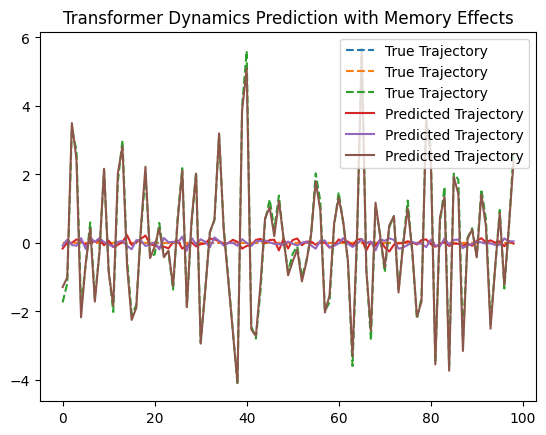

In [5]:
with torch.no_grad():
    sample_input = X_train[0:1]
    predicted_trajectory = model(sample_input).squeeze().numpy()
    true_trajectory = Y_train[0].squeeze().numpy()

# Plot results
plt.plot(true_trajectory, label="True Trajectory", linestyle='dashed')
plt.plot(predicted_trajectory, label="Predicted Trajectory")
plt.legend()
plt.title("Transformer Dynamics Prediction with Memory Effects")
plt.show()